In [1]:
import datetime as dt
from datetime import date
from datetime import datetime
from datetime import timedelta
import pandas as pd
import geopandas as gpd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from shapely.geometry import LineString, Point
import pyproj
from shapely.ops import transform
import networkx as nx
import momepy

/home/twenty/miniconda3/lib/python3.9/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.0-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(


In [2]:
routes = pd.read_csv('data/hk/headway/routes.txt')

In [3]:
trips = pd.read_csv('data/hk/headway/trips.txt')

In [4]:
stops = pd.read_csv('data/hk/headway/stops.txt')

In [5]:
stop_times = pd.read_csv('data/hk/headway/stop_times.txt')

In [6]:
routes.head()

,route_id,agency_id,route_short_name,route_long_name,route_type,route_url
0,1001,KMB,1,CHUK YUEN ESTATE - STAR FERRY,3,https://search.kmb.hk/KMBWebSite/?action=route...
1,1002,KMB,10,CHOI WAN - TAI KOK TSUI (CIRCULAR),3,https://search.kmb.hk/KMBWebSite/?action=route...
2,1006,KMB+CTB,102P,SHAU KEI WAN - MEI FOO,3,https://search.kmb.hk/KMBWebSite/?action=route...
3,1008,KMB+CTB,103,CHUK YUEN ESTATE - POKFIELD RD,3,https://search.kmb.hk/KMBWebSite/?action=route...
4,1010,KMB+NWFB,106,WONG TAI SIN - SIU SAI WAN (ISLAND RESORT),3,https://search.kmb.hk/KMBWebSite/?action=route...


## Filter trips that are buses (ie, not ferry, not GMB)

In [7]:
# exclude ferry, peak tram, hki trams, and GMB
conds = (routes.agency_id != 'FERRY') & (routes.agency_id != 'PTRAM') & (routes.agency_id != 'TRAM') & (routes.agency_id != 'GMB')
bus_routes = routes[conds]

In [8]:
bus_routes.agency_id.unique()

array(['KMB', 'KMB+CTB', 'KMB+NWFB', 'LWB', 'LWB+CTB', 'NWFB', 'CTB',
       'NLB', 'LRTFeeder', 'XB', 'DB', 'PI'], dtype=object)

In [9]:
bus_trips = bus_routes.merge(trips, on='route_id', how='inner')
bus_trips.head()

,route_id,agency_id,route_short_name,route_long_name,route_type,route_url,service_id,trip_id
0,1001,KMB,1,CHUK YUEN ESTATE - STAR FERRY,3,https://search.kmb.hk/KMBWebSite/?action=route...,287,1001-1-287-0535
1,1001,KMB,1,CHUK YUEN ESTATE - STAR FERRY,3,https://search.kmb.hk/KMBWebSite/?action=route...,287,1001-1-287-0623
2,1001,KMB,1,CHUK YUEN ESTATE - STAR FERRY,3,https://search.kmb.hk/KMBWebSite/?action=route...,287,1001-1-287-0647
3,1001,KMB,1,CHUK YUEN ESTATE - STAR FERRY,3,https://search.kmb.hk/KMBWebSite/?action=route...,287,1001-1-287-0757
4,1001,KMB,1,CHUK YUEN ESTATE - STAR FERRY,3,https://search.kmb.hk/KMBWebSite/?action=route...,287,1001-1-287-0829


In [10]:
assert trips.shape[0] > bus_trips.shape[0]

In [11]:
bus_stop_times = stop_times[stop_times.trip_id.isin(bus_trips.trip_id)]
bus_stop_times

,trip_id,arrival_time,departure_time,stop_id,stop_sequence,pickup_type,drop_off_type,timepoint
0,1001-1-287-0535,05:35:00,05:35:00,4001,1,0,1,1
1,1001-1-287-0535,NaN,NaN,4002,2,0,0,0
2,1001-1-287-0535,NaN,NaN,4003,3,0,0,0
3,1001-1-287-0535,NaN,NaN,4004,4,0,0,0
4,1001-1-287-0535,NaN,NaN,4005,5,0,0,0
...,...,...,...,...,...,...,...,...
552705,1000211-1-287-0730,NaN,NaN,1371,16,0,0,0
552706,1000211-1-287-0730,NaN,NaN,1148,17,0,0,0
552707,1000211-1-287-0730,NaN,NaN,8340,18,0,0,0
552708,1000211-1-287-0730,NaN,NaN,10265,19,0,0,0


## Some GMB routes do not have intermediate stops, see below

In [12]:
#num_stops_in_every_trip.sort_values()

In [13]:
# stop_times[stop_times.trip_id.str.startswith('2042-1-287')]

In [14]:
# trips[trips.trip_id == '2042-1-287-0730']

In [15]:
# bus_routes[bus_routes.route_id == 2042]

In [16]:
# stop_times[stop_times.trip_id == '2042-1-287-0730']

Manually checked route 33M, it is indeed circular, shuttling between 2 stops

In [17]:
# num_stops_in_every_trip[num_stops_in_every_trip == 2].count()

In [18]:
# trips[trips.trip_id == '2003-1-287-0700']

In [19]:
# bus_routes[bus_routes.route_id == 2003]

In [20]:
# bus_routes[bus_routes.route_id == 2003].route_long_name.iloc[0]

In [21]:
# stop_times[stop_times.trip_id == '2003-1-287-0700']

In [22]:
# stop_times[stop_times.trip_id.str.startswith('2003-')]

In [23]:
# idxes = num_stops_in_every_trip[num_stops_in_every_trip == 1].index
# idxes

In [24]:
# test = bus_trips[bus_trips.trip_id.isin(idxes)]
# test

In [25]:
# test2 = bus_routes[bus_routes.route_id.isin(test.route_id.unique())]
# test2

In [26]:
#test2.agency_id.unique()

## Manual checks with map

https://www.hkemobility.gov.hk/en/public-transport/bus

In [27]:
trips[trips.trip_id == '8071-1-448-0830']

,route_id,service_id,trip_id
18286,8071,448,8071-1-448-0830


In [28]:
routes[routes.route_id == 8071]

,route_id,agency_id,route_short_name,route_long_name,route_type,route_url
674,8071,NLB,1R,HUNG HOM (HUNG LUEN ROAD) - NGONG PING,3,http://www.nlb.com.hk/route?q=1R


In [29]:
trips[trips.trip_id == '1000193-1-287-0015']

,route_id,service_id,trip_id
22306,1000193,287,1000193-1-287-0015


In [30]:
routes[routes.route_id == 1000193]

,route_id,agency_id,route_short_name,route_long_name,route_type,route_url
1427,1000193,DB,DB08R,DISCOVERY BAY - CENTRAL (CENTRAL PIER NO. 3),3,https://www.td.gov.hk/en/transport_in_hong_kon...


In [31]:
trips[trips.trip_id == '1000209-2-287-2007']

,route_id,service_id,trip_id
22386,1000209,287,1000209-2-287-2007


In [32]:
routes[routes.route_id == 1000209]

,route_id,agency_id,route_short_name,route_long_name,route_type,route_url
1436,1000209,LWB,E37C,TIN SHUI WAI TOWN CENTRE - AIRCRAFT MAINTENANC...,3,https://search.kmb.hk/KMBWebSite/?action=route...


In [33]:
trips[trips.trip_id == '1271-1-287-0732']

,route_id,service_id,trip_id
7139,1271,287,1271-1-287-0732


In [34]:
routes[routes.route_id == 1271]

,route_id,agency_id,route_short_name,route_long_name,route_type,route_url
221,1271,KMB+CTB,619X,SHUN LEE - CENTRAL (MACAU FERRY),3,https://search.kmb.hk/KMBWebSite/?action=route...


In [35]:
trips[trips.trip_id == '1993-2-287-0601']

,route_id,service_id,trip_id
18187,1993,287,1993-2-287-0601


In [36]:
routes[routes.route_id == 1993]

,route_id,agency_id,route_short_name,route_long_name,route_type,route_url
666,1993,XB,Wan Chai - Huanggang (Day),WAN CHAI - HUANGGANG,3,http://www.td.gov.hk/en/transport_in_hong_kong...


In [37]:
trips[trips.trip_id == '8194-2-287-0715']

,route_id,service_id,trip_id
18779,8194,287,8194-2-287-0715


In [38]:
routes[routes.route_id == 8194]

,route_id,agency_id,route_short_name,route_long_name,route_type,route_url
759,8194,KMB+NWFB,101X,KENNEDY TOWN - KWUN TONG (YUE MAN SQUARE),3,https://search.kmb.hk/KMBWebSite/?action=route...


# Number of bus routes

In [39]:
bus_routes.route_long_name.unique().shape

(1354,)

In [40]:
bus_routes.route_id.unique().shape

(1438,)

In [41]:
bus_routes.route_id.shape

(1438,)

# Number of bus stops

In [42]:
bus_stop_times.stop_id.unique().shape

(4282,)

# Average number of bus stops per bus route

In [43]:
# stop_sequences means entire thing has no duplicates
trip_to_stop_id = bus_stop_times#[['trip_id', 'stop_id', 'stop_sequence']].drop_duplicates()
trip_to_stop_id

,trip_id,arrival_time,departure_time,stop_id,stop_sequence,pickup_type,drop_off_type,timepoint
0,1001-1-287-0535,05:35:00,05:35:00,4001,1,0,1,1
1,1001-1-287-0535,NaN,NaN,4002,2,0,0,0
2,1001-1-287-0535,NaN,NaN,4003,3,0,0,0
3,1001-1-287-0535,NaN,NaN,4004,4,0,0,0
4,1001-1-287-0535,NaN,NaN,4005,5,0,0,0
...,...,...,...,...,...,...,...,...
552705,1000211-1-287-0730,NaN,NaN,1371,16,0,0,0
552706,1000211-1-287-0730,NaN,NaN,1148,17,0,0,0
552707,1000211-1-287-0730,NaN,NaN,8340,18,0,0,0
552708,1000211-1-287-0730,NaN,NaN,10265,19,0,0,0


In [44]:
num_stops_in_every_trip = trip_to_stop_id.groupby('trip_id').stop_id.count()
num_stops_in_every_trip

trip_id
1000001-1-287-0750    21
1000002-1-287-1810    16
1000003-1-287-0730    27
1000004-1-511-0630    18
1000004-1-511-0700    18
                      ..
8803-2-511-2240       28
8803-2-511-2310       28
8804-1-511-0600       20
8805-1-511-0515       31
8805-2-511-2325       30
Name: stop_id, Length: 22390, dtype: int64

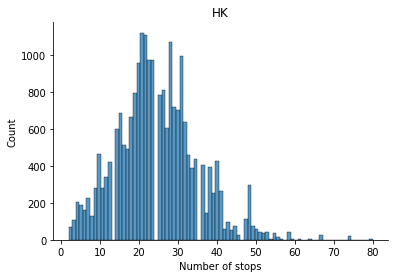

In [45]:
sns.histplot(x=num_stops_in_every_trip)
plt.xlabel('Number of stops')
plt.title('HK')
sns.despine()
plt.savefig('figures/hk_nstops.png')

In [46]:
num_stops_in_every_trip.mean()

24.6855739169272

In [47]:
num_stops_in_every_trip.median()

24.0

In [48]:
#num_stops_in_every_trip.to_csv('gen/hk_nstops.csv')

# Comparison needs route, not trips

In [49]:
num_stops_in_every_route = bus_trips[['route_id', 'trip_id']].merge(num_stops_in_every_trip, on='trip_id')
num_stops_in_every_route

,route_id,trip_id,stop_id
0,1001,1001-1-287-0535,25
1,1001,1001-1-287-0623,25
2,1001,1001-1-287-0647,25
3,1001,1001-1-287-0757,25
4,1001,1001-1-287-0829,25
...,...,...,...
22385,1000208,1000208-1-319-0820,4
22386,1000209,1000209-1-287-0620,28
22387,1000209,1000209-2-287-2007,29
22388,1000210,1000210-1-287-0625,19


In [50]:
num_stops_in_every_route = num_stops_in_every_route[['route_id', 'stop_id']]

In [51]:
# Only need one number for every route; routes are duplicated because it has multiple trips
num_stops_in_every_route = num_stops_in_every_route.drop_duplicates()

In [52]:
num_stops_in_every_route.to_csv('./gen/hk_nstops.csv', index=False)

# Average route length

In [53]:
# wgs84 is in degrees, pseudo mercator is in meters
wgs84 = pyproj.CRS('EPSG:4326')
pseudo_mercator = pyproj.CRS('EPSG:3857')
project = pyproj.Transformer.from_crs(wgs84, pseudo_mercator, always_xy=True).transform

def transformer(p: Point):
    return transform(project, p)

In [54]:
stop_times_with_loc = bus_stop_times.merge(stops, on='stop_id')
stop_times_with_loc.head()

,trip_id,arrival_time,departure_time,stop_id,stop_sequence,pickup_type,drop_off_type,timepoint,stop_name,stop_lat,stop_lon,zone_id,location_type,stop_timezone
0,1001-1-287-0535,05:35:00,05:35:00,4001,1,0,1,1,[CTB] CHUK YUEN ESTATE|[KMB+CTB] CHUK YUEN EST...,22.34535,114.19244,4001,0,Asia/Hong_Kong
1,1001-1-287-0623,06:23:00,06:23:00,4001,1,0,1,1,[CTB] CHUK YUEN ESTATE|[KMB+CTB] CHUK YUEN EST...,22.34535,114.19244,4001,0,Asia/Hong_Kong
2,1001-1-287-0647,06:47:00,06:47:00,4001,1,0,1,1,[CTB] CHUK YUEN ESTATE|[KMB+CTB] CHUK YUEN EST...,22.34535,114.19244,4001,0,Asia/Hong_Kong
3,1001-1-287-0757,07:57:00,07:57:00,4001,1,0,1,1,[CTB] CHUK YUEN ESTATE|[KMB+CTB] CHUK YUEN EST...,22.34535,114.19244,4001,0,Asia/Hong_Kong
4,1001-1-287-0829,08:29:00,08:29:00,4001,1,0,1,1,[CTB] CHUK YUEN ESTATE|[KMB+CTB] CHUK YUEN EST...,22.34535,114.19244,4001,0,Asia/Hong_Kong


In [55]:
#stop_times_with_loc = stop_times_with_loc[stop_times_with_loc.trip_id.isin(bus_trips.trip_id)]

In [56]:
def f(x):
    df = x.sort_values('stop_sequence')
    points = df[['stop_lon', 'stop_lat']].apply(
        lambda row: transformer(Point(row.stop_lon, row.stop_lat)),
        axis=1
    )
    return LineString(points.reset_index(drop=True))

trip_lines = stop_times_with_loc.groupby('trip_id').apply(f)
trip_lines

trip_id
1000001-1-287-0750    LINESTRING (12705867.52978075 2556085.96445838...
1000002-1-287-1810    LINESTRING (12713733.36500021 2562811.69123546...
1000003-1-287-0730    LINESTRING (12716338.24108477 2543284.91935929...
1000004-1-511-0630    LINESTRING (12704733.18416957 2555692.32944062...
1000004-1-511-0700    LINESTRING (12704733.18416957 2555692.32944062...
                                            ...                        
8803-2-511-2240       LINESTRING (12683516.80241928 2549143.93513729...
8803-2-511-2310       LINESTRING (12683516.80241928 2549143.93513729...
8804-1-511-0600       LINESTRING (12687906.12994126 2561411.17835715...
8805-1-511-0515       LINESTRING (12692180.79838772 2555126.57053090...
8805-2-511-2325       LINESTRING (12683516.80241928 2549143.93513729...
Length: 22390, dtype: object

In [57]:
trip_lengths = trip_lines.apply(lambda x: x.length)
trip_lengths

trip_id
1000001-1-287-0750    16251.904798
1000002-1-287-1810    15921.906291
1000003-1-287-0730     9912.221455
1000004-1-511-0630    26455.963842
1000004-1-511-0700    26455.963842
                          ...     
8803-2-511-2240       19710.448439
8803-2-511-2310       19710.448439
8804-1-511-0600       15452.704964
8805-1-511-0515       21053.241753
8805-2-511-2325       21546.326053
Length: 22390, dtype: float64

In [58]:
# Average trip length in meters
trip_lengths.mean()

16679.390887073783

In [59]:
trip_lengths.median()

15096.74230852681

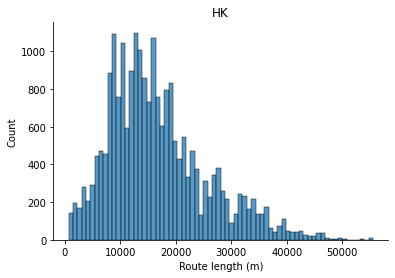

In [60]:
sns.histplot(x=trip_lengths)
sns.despine()
plt.title('HK')
plt.xlabel('Route length (m)')
plt.savefig('figures/hk_rlengths.png')

In [61]:
#trip_lengths.to_csv('gen/hk_rlengths.csv')

In [62]:
trip_lengths.sort_values(ascending=False).head()

trip_id
1893-1-511-0350    55515.803551
1893-1-511-0420    55515.803551
1893-1-511-0450    55515.803551
1893-2-511-0110    55455.881906
1893-2-511-0015    55455.881906
dtype: float64

# Comparison need route not trip lengths

In [63]:
trip_lengths.name = 'Length'

In [64]:
route_lengths = bus_trips[['route_id', 'trip_id']].merge(trip_lengths, on='trip_id')
route_lengths

,route_id,trip_id,Length
0,1001,1001-1-287-0535,8640.700522
1,1001,1001-1-287-0623,8640.700522
2,1001,1001-1-287-0647,8640.700522
3,1001,1001-1-287-0757,8640.700522
4,1001,1001-1-287-0829,8640.700522
...,...,...,...
22385,1000208,1000208-1-319-0820,13490.223853
22386,1000209,1000209-1-287-0620,29479.526566
22387,1000209,1000209-2-287-2007,29900.782583
22388,1000210,1000210-1-287-0625,36974.009651


In [65]:
route_lengths = route_lengths[['route_id', 'Length']]

In [66]:
route_lengths = route_lengths.drop_duplicates()

In [67]:
route_lengths.to_csv('./gen/hk_rlengths.csv', index=False)

# Map of bus network

In [68]:
gdf = gpd.GeoDataFrame(trip_lines, columns=['geometry'])

In [69]:
gdf.head()

,geometry
trip_id,
1000001-1-287-0750,"LINESTRING (12705867.530 2556085.964, 12705961..."
1000002-1-287-1810,"LINESTRING (12713733.365 2562811.691, 12713669..."
1000003-1-287-0730,"LINESTRING (12716338.241 2543284.919, 12716459..."
1000004-1-511-0630,"LINESTRING (12704733.184 2555692.329, 12704845..."
1000004-1-511-0700,"LINESTRING (12704733.184 2555692.329, 12704845..."


<AxesSubplot:>

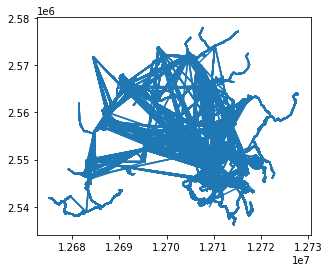

In [70]:
gdf.plot()

In [71]:
gdf.to_file('gen/hk_bus_routes.shp')

## confirming sequence

In [72]:
trips[trips.trip_id ==  '1583-1-287-0723']

,route_id,service_id,trip_id
13109,1583,287,1583-1-287-0723


In [73]:
bus_routes[bus_routes.route_id == 1583]

,route_id,agency_id,route_short_name,route_long_name,route_type,route_url
414,1583,NWFB,682,LEE ON - CHAI WAN (EAST),3,https://mobile.bravobus.com.hk/nwp3/?f=1&ds=68...


In [74]:
stop_times[stop_times.trip_id == '1583-1-287-0723']

,trip_id,arrival_time,departure_time,stop_id,stop_sequence,pickup_type,drop_off_type,timepoint
318581,1583-1-287-0723,07:23:00,07:23:00,6169,1,0,1,1
318582,1583-1-287-0723,NaN,NaN,6168,2,0,0,0
318583,1583-1-287-0723,NaN,NaN,6165,3,0,0,0
318584,1583-1-287-0723,NaN,NaN,6175,4,0,0,0
318585,1583-1-287-0723,NaN,NaN,1106,5,0,0,0
318586,1583-1-287-0723,NaN,NaN,6160,6,0,0,0
318587,1583-1-287-0723,NaN,NaN,1108,7,0,0,0
318588,1583-1-287-0723,NaN,NaN,6151,8,0,0,0
318589,1583-1-287-0723,NaN,NaN,6117,9,0,0,0
318590,1583-1-287-0723,NaN,NaN,1100,10,0,0,0


In [75]:
stops[stops.stop_id == 12983]

,stop_id,stop_name,stop_lat,stop_lon,zone_id,location_type,stop_timezone
3802,12983,"[CTB] HARMONY GARDEN, SIU SAI WAN ROAD|[KMB+CT...",22.26462,114.24824,12983,0,Asia/Hong_Kong


In [76]:
stops[stops.stop_id == 914]

,stop_id,stop_name,stop_lat,stop_lon,zone_id,location_type,stop_timezone
637,914,"[CTB] CHEERFUL GARDEN, SIU SAI WAN ROAD|[NWFB]...",22.26249,114.25027,914,0,Asia/Hong_Kong


In [77]:
stops[stops.stop_id == 915]

,stop_id,stop_name,stop_lat,stop_lon,zone_id,location_type,stop_timezone
638,915,"[CTB] FULLVIEW GARDEN, SIU SAI WAN ROAD|[NWFB]...",22.26357,114.25185,915,0,Asia/Hong_Kong


In [78]:
stops[stops.stop_id == 916]

,stop_id,stop_name,stop_lat,stop_lon,zone_id,location_type,stop_timezone
639,916,[KMB] SIU SAI WAN SPORTS GROUND|[NWFB] SIU SAI...,22.2664,114.24847,916,0,Asia/Hong_Kong


## seems to have ferries, need to remove

In [79]:
trips[trips.trip_id == '7016-1-288-0900']

,route_id,service_id,trip_id
25237,7016,288,7016-1-288-0900


In [80]:
bus_routes[bus_routes.route_id == 7016]

,route_id,agency_id,route_short_name,route_long_name,route_type,route_url


In [81]:
routes.agency_id.unique()

array(['KMB', 'KMB+CTB', 'KMB+NWFB', 'LWB', 'LWB+CTB', 'NWFB', 'CTB',
       'NLB', 'LRTFeeder', 'XB', 'DB', 'PI', 'GMB', 'FERRY', 'PTRAM',
       'TRAM'], dtype=object)

# Average distance between stops

In [82]:
def calc_distances(x):
    '''
    input: [(float, float)]
        a list of coordinates
    output: [float]
        the distances between each coordinates
    '''
    return [Point(a).distance(Point(b)) for a, b in zip(x, x[1:])]

In [83]:
def f(x):
    df = x.sort_values('stop_sequence')
    points = df[['stop_lon', 'stop_lat']].apply(
        lambda row: transformer(Point(row.stop_lon, row.stop_lat)),
        axis=1
    )
    return calc_distances(points.reset_index(drop=True))

trip_stop_dists = stop_times_with_loc.groupby('trip_id').apply(f)
trip_stop_dists

trip_id
1000001-1-287-0750    [221.7173949923343, 464.371135741395, 541.7150...
1000002-1-287-1810    [71.85531037179265, 385.97822178236294, 364.36...
1000003-1-287-0730    [173.41590726816406, 147.5033219474707, 146.01...
1000004-1-511-0630    [206.61270050926788, 440.96460042560307, 324.5...
1000004-1-511-0700    [206.61270050926788, 440.96460042560307, 324.5...
                                            ...                        
8803-2-511-2240       [6789.557865971986, 1537.4377922321773, 420.26...
8803-2-511-2310       [6789.557865971986, 1537.4377922321773, 420.26...
8804-1-511-0600       [594.2009656522827, 421.1248205682452, 596.602...
8805-1-511-0515       [527.2613587543468, 354.02940591808584, 419.91...
8805-2-511-2325       [6789.557865971986, 1537.4377922321773, 420.26...
Length: 22390, dtype: object

In [84]:
trip_avg_stop_dists = trip_stop_dists.apply(np.mean)
trip_avg_stop_dists

trip_id
1000001-1-287-0750     812.595240
1000002-1-287-1810    1061.460419
1000003-1-287-0730     381.239287
1000004-1-511-0630    1556.233167
1000004-1-511-0700    1556.233167
                         ...     
8803-2-511-2240        730.016609
8803-2-511-2310        730.016609
8804-1-511-0600        813.300261
8805-1-511-0515        701.774725
8805-2-511-2325        742.976760
Length: 22390, dtype: float64

In [85]:
# Global average distance between stops (meters)
trip_avg_stop_dists.mean()

864.9109231970274

In [86]:
trip_avg_stop_dists.median()

581.0095810241379

<AxesSubplot:ylabel='Count'>

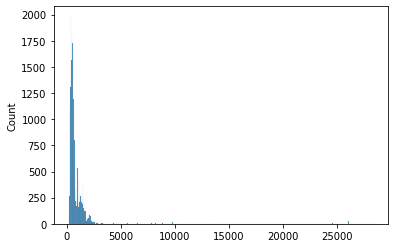

In [87]:
sns.histplot(x=trip_avg_stop_dists)

In [88]:
# The individual distances between every stops in every route
trip_stop_dists.explode().astype(float).describe()

count    530320.000000
mean        704.200411
std        1594.318902
min           8.236476
25%         268.748435
50%         385.268395
75%         559.881846
max       31011.840537
dtype: float64

<AxesSubplot:>

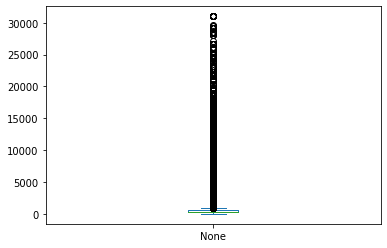

In [89]:
trip_stop_dists.explode().astype(float).plot.box()

In [90]:
trip_avg_stop_dists.sort_values(ascending=False)

trip_id
1992-1-511-0330    28327.860920
8239-1-511-0600    28327.860920
1992-1-511-0500    28327.860920
1992-1-511-2330    28327.860920
1992-1-511-0200    28327.860920
                       ...     
1509-1-287-1900      209.028123
1509-1-287-1600      209.028123
1509-1-287-1020      209.028123
1509-1-287-0935      209.028123
1509-1-288-0630      209.028123
Length: 22390, dtype: float64

In [91]:
#trip_avg_stop_dists.to_csv('gen/hk_stop_dists.csv')

In [92]:
trip_avg_stop_dists = pd.DataFrame(trip_avg_stop_dists)
trip_avg_stop_dists

,0
trip_id,
1000001-1-287-0750,812.595240
1000002-1-287-1810,1061.460419
1000003-1-287-0730,381.239287
1000004-1-511-0630,1556.233167
1000004-1-511-0700,1556.233167
...,...
8803-2-511-2240,730.016609
8803-2-511-2310,730.016609
8804-1-511-0600,813.300261


In [93]:
trip_avg_stop_dists.columns = ['distance']

In [94]:
trip_avg_stop_dists.reset_index(inplace=True)

In [95]:
route_avg_stop_dists = bus_trips.merge(trip_avg_stop_dists, on='trip_id')
route_avg_stop_dists

,route_id,agency_id,route_short_name,route_long_name,route_type,route_url,service_id,trip_id,distance
0,1001,KMB,1,CHUK YUEN ESTATE - STAR FERRY,3,https://search.kmb.hk/KMBWebSite/?action=route...,287,1001-1-287-0535,360.029188
1,1001,KMB,1,CHUK YUEN ESTATE - STAR FERRY,3,https://search.kmb.hk/KMBWebSite/?action=route...,287,1001-1-287-0623,360.029188
2,1001,KMB,1,CHUK YUEN ESTATE - STAR FERRY,3,https://search.kmb.hk/KMBWebSite/?action=route...,287,1001-1-287-0647,360.029188
3,1001,KMB,1,CHUK YUEN ESTATE - STAR FERRY,3,https://search.kmb.hk/KMBWebSite/?action=route...,287,1001-1-287-0757,360.029188
4,1001,KMB,1,CHUK YUEN ESTATE - STAR FERRY,3,https://search.kmb.hk/KMBWebSite/?action=route...,287,1001-1-287-0829,360.029188
...,...,...,...,...,...,...,...,...,...
22385,1000208,NLB,36X,MUN TUNG ESTATE - DISNEYLAND,3,http://www.nlb.com.hk/route?q=36X#,319,1000208-1-319-0820,4496.741284
22386,1000209,LWB,E37C,TIN SHUI WAI TOWN CENTRE - AIRCRAFT MAINTENANC...,3,https://search.kmb.hk/KMBWebSite/?action=route...,287,1000209-1-287-0620,1091.834317
22387,1000209,LWB,E37C,TIN SHUI WAI TOWN CENTRE - AIRCRAFT MAINTENANC...,3,https://search.kmb.hk/KMBWebSite/?action=route...,287,1000209-2-287-2007,1067.885092
22388,1000210,LWB,E42C,POK HONG - AIRCRAFT MAINTENANCE AREA,3,https://search.kmb.hk/KMBWebSite/?action=route...,287,1000210-1-287-0625,2054.111647


In [96]:
route_avg_stop_dists_ = route_avg_stop_dists.groupby('route_id')['distance'].mean()
route_avg_stop_dists_

route_id
1001        364.932494
1002        373.773440
1006        547.914668
1008        446.814018
1010        406.577768
              ...     
1000207    1085.143987
1000208    4496.741284
1000209    1079.859705
1000210    2047.796860
1000211     616.028241
Name: distance, Length: 1438, dtype: float64

<AxesSubplot:>

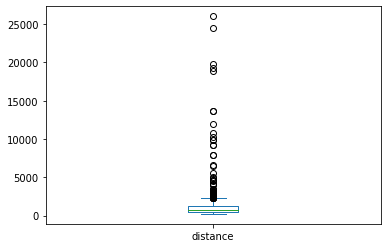

In [97]:
route_avg_stop_dists_.plot.box()

In [98]:
route_avg_stop_dists_.to_csv('gen/hk_stop_dists.csv')

In [99]:
route_avg_stop_dists_.sort_values()

route_id
8146         210.236948
1000072      211.449586
1527         220.840719
1196         220.921939
8655         225.939365
               ...     
8239       18903.089833
1992       19237.024592
1991       19833.776696
1999       24562.061322
8250       26036.886216
Name: distance, Length: 1438, dtype: float64

In [100]:
bus_routes[bus_routes.route_id == 8250]

,route_id,agency_id,route_short_name,route_long_name,route_type,route_url
821,8250,XB,Mong Kok - Huanggang (Night),MONG KOK - HUANGGANG,3,http://www.td.gov.hk/en/transport_in_hong_kong...
